# Case Study on Loss Given Default

# Context: 
    
CNB Bank deals in all kinds of car loans. Customer first apply for loan after that company validates the customer 
eligibility for loan. In case the borrower doesn’t pay back the loan, the losses are to be incurred by the bank.
LGD stands for Loss given default so it means when a customer at a bank defaults on his loan how much money does the bank lose. 
The customer might have paid some amount back or no amount at all.The bank wants to know if the amount the bank loses can be 
predicted for new customers who apply for a loan from the past data of all defaulters and their pending amounts

# Problem:

The bank wants to automate the loss estimation based on customer detail provided while applying for loan. These details are Age, 
Years of Experience, Number of cars, Gender, Marital Status. To automate this process, they have given a problem to identify the 
loss estimation given that the customers is a defaulter, those are eligible for loan amount so that they get to know what 
features are leading to defaults up to which amount. Here are the details about the data set.

Data:

* Variable - Description
* Ac_No - The account of customer used as identifier
* Age - Age of borrower (16-70)
* Years of Experience - Working experience (0-53)
* Number of Cars - Possessed cars (1, 2, 3, 4)
* Gender - Male/Female
* Married - Married/Single
* Loss in Thousands - Target variable


In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # this is for visualization
import seaborn as sns # for visualization
%matplotlib inline
import statsmodels.formula.api as sm
import scipy, scipy.stats
import math # log function is inside this library
# this is used to get the plots inline i.e. in the same page
from collections import Counter

In [14]:
# read the csv file into a dataframe
df=pd.read_csv("LGD.csv")
df.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands
0,150024,24,5,1,M,Married,203.319595
1,144880,31,10,1,F,Single,402.197302
2,133742,56,37,1,M,Married,553.132096
3,151282,52,31,1,F,Married,292.430579
4,174407,20,3,1,M,Single,246.540576


In [15]:
#The Ac_No is a redundant column - so we will remove it
df.drop(['Ac_No'], axis=1, inplace=True)

In [16]:
# lets do a basic EDA ( exploratory data analysis) on the file
df.info() # this tells us 15290 rows & 7 columns
#df.shape will also give the same info
#df.info also tells us there are no NULL values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15290 entries, 0 to 15289
Data columns (total 6 columns):
Age                    15290 non-null int64
Years of Experience    15290 non-null int64
Number of Vehicles     15290 non-null int64
Gender                 15290 non-null object
Married                15290 non-null object
Losses in Thousands    15290 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 716.8+ KB


#### Although number of vehicles is a numerical variable in the dataset, it would be better to convert it to a categorical variable so that we dont fractions in number of vehicles

In [17]:
df['Number of Vehicles']=df['Number of Vehicles'].astype('category')

## Univariate analysis
* Numerical variables - boxplot, histogram
* Categorical variables - value_count

# Visualize numeric variables in boxplot and histograms

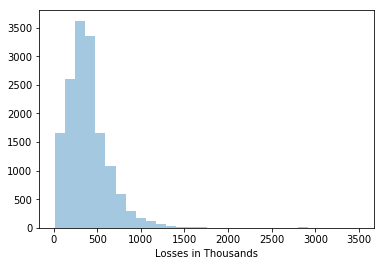

In [18]:
#to plot histograms
sns.distplot(df['Losses in Thousands'],kde=False,bins=30)

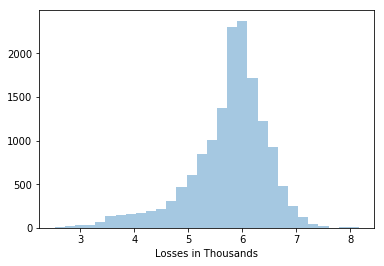

In [19]:
# this probably means we should take the log to normalize the data
sns.distplot(np.log(df['Losses in Thousands']),kde=False,bins=30)

# now the distribution looks normal

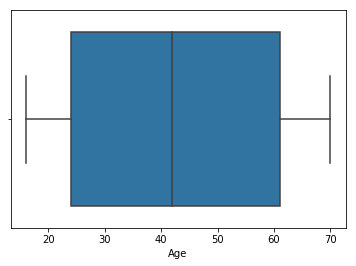

In [12]:
sns.boxplot(df['Age'])

#### The median age is 42

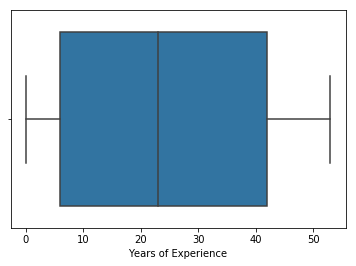

In [13]:
sns.boxplot(df['Years of Experience'])

#  Explore categorical variables

In [20]:
df['Number of Vehicles'].value_counts(normalize=True)

2    0.336952
3    0.333224
1    0.165664
4    0.164160
Name: Number of Vehicles, dtype: float64

**About 1/3 of the sample have 2 vehicles another 1/3 have 3 vehicles**

In [21]:
df['Gender'].value_counts(normalize=True)

F    0.506671
M    0.493329
Name: Gender, dtype: float64

**There is a fairly even gender balance in the dataset**

In [23]:
df['Married'].value_counts(normalize=True)

Married    0.509026
Single     0.490974
Name: Married, dtype: float64

**The dataset has an almost equal percentage of married and single customers**

## Bivariate analysis
Since this is a regerssion problem where the Y variable is numeric, the plots that will help us analyse the impact of X variables on Y are

* 2 Numerical variables - scatterplot & correlation
* NUmerical vs categorical - Boxplot


## Explore relationships between variables using scatterplots & correlation

In [24]:
df.corr()
# we see a high co-relation between Age and Years of Experience 

,Age,Years of Experience,Losses in Thousands
Age,1.000000,0.997161,-0.442962
Years of Experience,0.997161,1.000000,-0.442115
Losses in Thousands,-0.442962,-0.442115,1.000000


**The Y variable Losses in Thousands has a negative correlation of ~45% with both age an experience. This means that age and experience increase, loss decreases**

**Also note that there is very high correlation between Age and Years of experience. This will be addressed in subsequent weeks**

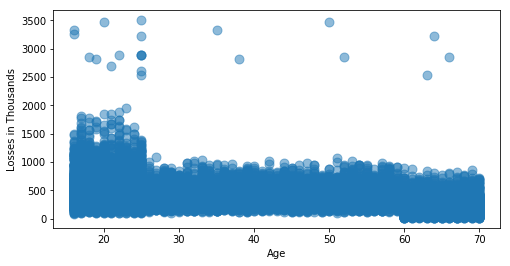

In [25]:
#Visualizing relationships – scatterplots
df.plot.scatter(y='Losses in Thousands',x='Age',alpha=0.5,figsize=(8,4),s=80)

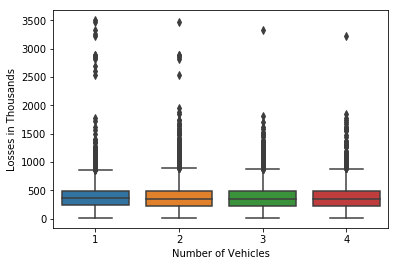

In [26]:
#How loss varies with Number of vehicles
sns.boxplot(x=df['Number of Vehicles'], y=df['Losses in Thousands'])

**The median loss is almost the same across all the number of vehicles**

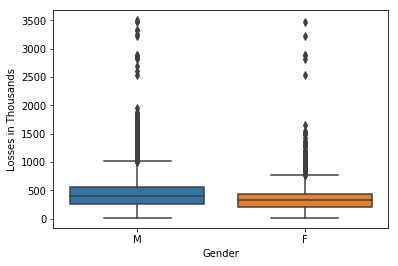

In [27]:
#How loss varies with Gender
sns.boxplot(x=df['Gender'], y=df['Losses in Thousands'])

**The median loss is lower for female compared to male customers**

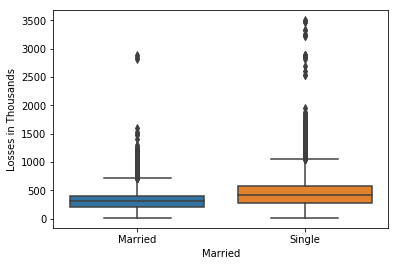

In [28]:
#How loss varies with marital status
sns.boxplot(x=df['Married'], y=df['Losses in Thousands'])

**The median loss is higher for customers who are single compared to married customers**

## Multivariate analysis
In this part of the analysis, we will understand the combined effect of more than one X variables on the loss

c:\python\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


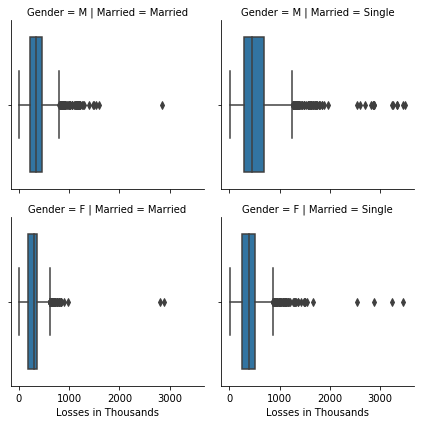

In [29]:
g = sns.FacetGrid(df, col="Married", row='Gender')
g.map(sns.boxplot, "Losses in Thousands")

**The median loss is highest for single males**

In [32]:
#Cross tab of loss and color
pd.pivot_table(data=df, values='Losses in Thousands', index='Number of Vehicles', columns='Gender', aggfunc='mean')


Gender,F,M
Number of Vehicles,,
1,353.932196,441.748578
2,345.051020,436.505727
3,342.531803,431.585732
4,333.153706,446.040008


**The loss is highest for Male customers who own 4 vehicles**

## Model building

In [34]:
X = df.drop('Losses in Thousands', axis=1)
Y = df[['Losses in Thousands']]

In [35]:
#Convert categorical vriables to dummy variables
X = pd.get_dummies(X, drop_first=True)
X.columns

Index(['Age', 'Years of Experience', 'Number of Vehicles_2',
       'Number of Vehicles_3', 'Number of Vehicles_4', 'Gender_M',
       'Married_Single'],
      dtype='object')

In [36]:
#Split into train and test sets
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=1)

c:\python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
from statsmodels.api import add_constant
X2 = add_constant(x_train)
lm= sm.OLS(y_train,X2)
lm2=lm.fit()

const                    2.584788e-78
Age                      3.120781e-04
Years of Experience      5.964820e-01
Number of Vehicles_2     9.713309e-01
Number of Vehicles_3     6.426582e-01
Number of Vehicles_4     5.314348e-01
Gender_M                1.323057e-121
Married_Single          7.853401e-233
dtype: float64

In [40]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Losses in Thousands   R-squared:                       0.305
Model:                             OLS   Adj. R-squared:                  0.304
Method:                  Least Squares   F-statistic:                     669.2
Date:                 Thu, 23 May 2019   Prob (F-statistic):               0.00
Time:                         11:54:37   Log-Likelihood:                -72503.
No. Observations:                10703   AIC:                         1.450e+05
Df Residuals:                    10695   BIC:                         1.451e+05
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  522.6607     27.669     18.890      0.000     468.425     576.897
Age                     -5.3637      1.487     -3.606      0.000      -8.279      -2.448
Years of Experience     -0.8061      1.522     -0.529      0.596      -3.790       2.178
Number of Vehicles_2     0.2215      6.163      0.036      0.971     -11.860      12.303
Number of Vehicles_3    -2.8695      6.184     -0.464      0.643     -14.992       9.253
Number of Vehicles_4    -4.4764      7.153     -0.626      0.531     -18.497       9.544
Gender_M                97.2815      4.095     23.755      0.000      89.254     105.309
Married_Single         136.8109      4.095     33.406      0.000     128.783     144.839
==============================================================================
Omnibus:                     7905.244   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           404646.147
Skew:                           3.032   Prob(JB):                         0.00
Kurtosis:                      32.506   Cond. No.                         744.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
#to see the summary
print(lm2.summary())

                             OLS Regression Results                            
Dep. Variable:     Losses in Thousands   R-squared:                       0.305
Model:                             OLS   Adj. R-squared:                  0.304
Method:                  Least Squares   F-statistic:                     1171.
Date:                 Thu, 25 Oct 2018   Prob (F-statistic):               0.00
Time:                         17:20:05   Log-Likelihood:                -72503.
No. Observations:                10703   AIC:                         1.450e+05
Df Residuals:                    10698   BIC:                         1.451e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                539.6

In [41]:
#Filter only significant X variables (pval < 0.05) & sort descending by coef
regcoef = pd.DataFrame(lm2.params, columns=['coef'])
regcoef['pval']=lm2.pvalues
pd.options.display.float_format = '{:.2f}'.format


regcoef = regcoef.sort_values(by="coef", ascending=False)
pval_filter = regcoef['pval']<=0.05
regcoef[pval_filter]

,coef,pval
const,522.66,0.00
Married_Single,136.81,0.00
Gender_M,97.28,0.00
Age,-5.36,0.00


### Interpretation of regression summary
* The R sqaured for the model is 0.304. This implies that only 30.4% of the variation in the Y variable is explained by the current X variables. This indicates a low goodness of fit
* The significant X variables are listed above in order of their impact on Losses
* If the customer is Male, the loss increases by 136.81
* The other variables can also be similarly interpreted

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
lm3 = LinearRegression()

In [46]:
lm3.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
y_pred=lm3.predict(x_test)

In [54]:
#Model evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
mse = mean_squared_error(y_test, y_pred)
rms = sqrt(mse)


In [56]:
print("The Root Mean Sq Error is {}".format(rms))

The Root Mean Sq Error is 212.72698761789016


In [57]:
#Mean absolute percentage error
abs_error = np.abs(y_test-y_pred)
actual = y_test
mape = np.round(np.mean(abs_error/actual),3)
mape

Losses in Thousands   0.70
dtype: float64

**The error percentage is very high - 70%. This is because of the low R square value. We will learn how to improve model metrics in the subsequent sessions**